In this notebook, an exploratory analysis of shadowgram processing algorithms will be tried out to see what is the best approach.

# Import a shadowgram image from a concave mirror lens
First, pick a capture image from a Foucault test on a concave telescope mirror and show it.

In [1]:
import cv2

# Load our input image
#capture = cv2.imread('./Datasets/(165) 13_06_2019/1/Image_0.0.png')
#capture = cv2.imread('./Datasets/(165) 13_06_2019/1/Image_1.0.png')
capture = cv2.imread('./Datasets/(165) 13_06_2019/1/Image_1.0.png')
#capture = cv2.imread('./Datasets/(165) 13_06_2019/1/Image_2.0.png')

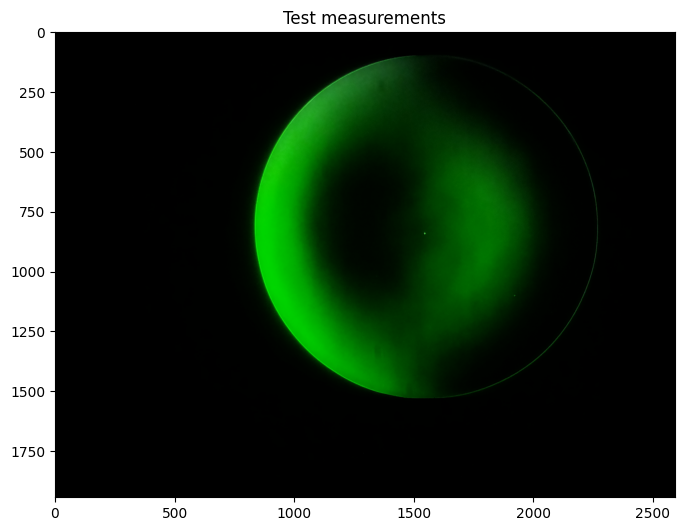

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture)
  
# display that image
plt.show()

# Convert captured image to grayscale

In [3]:
# convert color image into grayscale image
capture_gray = cv2.cvtColor(capture, cv2.COLOR_RGB2GRAY)

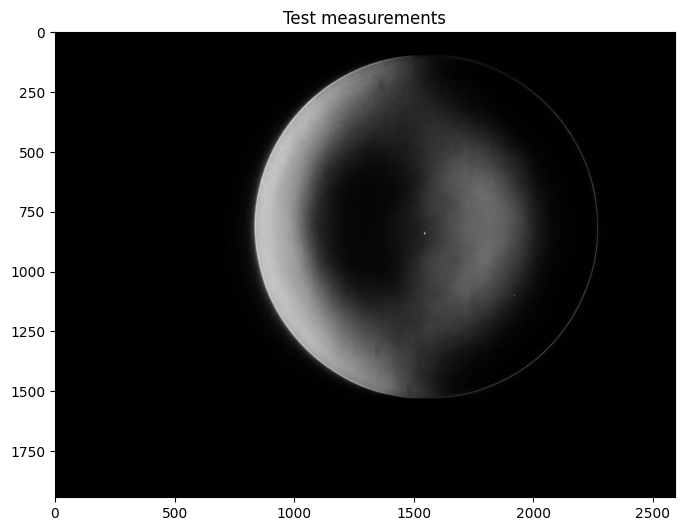

In [4]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_gray, cmap='gray')
  
# display that image
plt.show()

# Perform Canny edge detection algorithm on the grayscale image

In [5]:
#capture_gray_blur = cv2.blur(capture_gray, (3,3))
capture_gray_blur = cv2.bilateralFilter(capture_gray, 6, 6 * 2, 6 / 2)

canny_threshold = 40
capture_canny = cv2.Canny(capture_gray_blur, canny_threshold, canny_threshold*2, L2gradient=True)

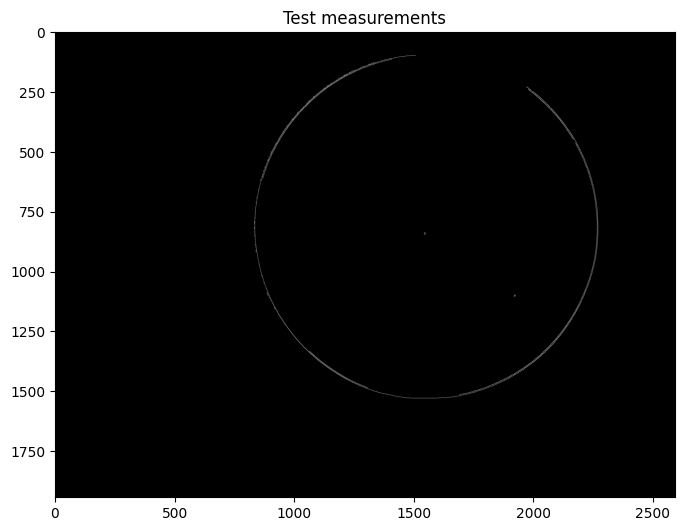

In [6]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_canny, cmap='gray')
  
# display that image
plt.show()

# Fit a circle to the (expected round) edge

In [7]:
import numpy as np

circles = cv2.HoughCircles(capture_gray, cv2.HOUGH_GRADIENT,
                           1, 800, param1=canny_threshold*2, param2=20, minRadius=400, maxRadius=1500)

if np.any(circles) != True:
  raise Exception("HoughCircles found no circles.")

if circles.size != 3:
    raise Exception("HoughCircles found more than one circle.")

circles = np.uint16(np.around(circles))
circles = circles[0, 0]

# draw fitted circle and inside and outside circles
circle_radius_tolerance = 30
line_thickness = 1
color_circle = (255, 0, 0)
center = (circles[0], circles[1])
radius = circles[2]
capture_circle = np.copy(capture)
capture_circle = cv2.circle(capture_circle, center, radius,
                            color_circle, line_thickness, cv2.LINE_AA)
capture_circle = cv2.circle(capture_circle, center, radius-circle_radius_tolerance,
                            color_circle, line_thickness, cv2.LINE_AA)
capture_circle = cv2.circle(capture_circle, center, radius+circle_radius_tolerance,
                            color_circle, line_thickness, cv2.LINE_AA)

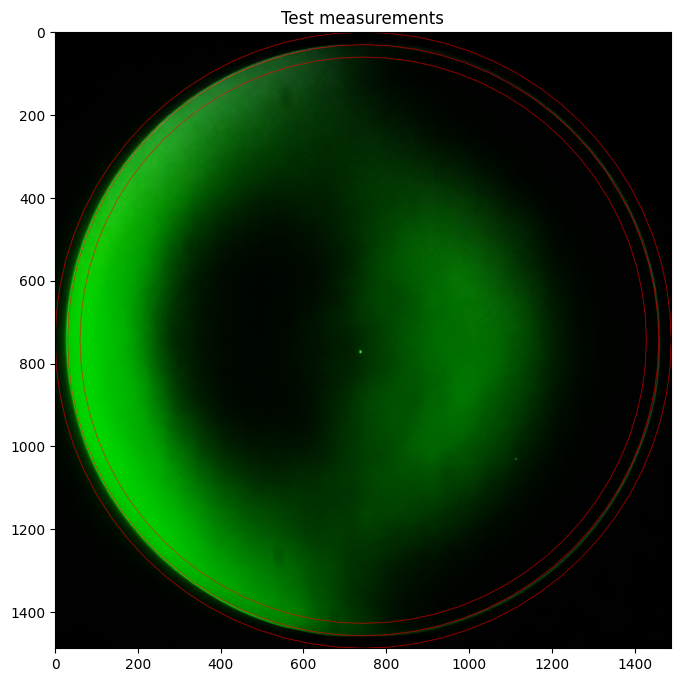

In [8]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_circle[center[1]-radius-circle_radius_tolerance:center[1]+radius+circle_radius_tolerance,
           center[0]-radius-circle_radius_tolerance:center[0]+radius+circle_radius_tolerance])
  
# display that image
plt.show()

# Fit an ellipse to the (expected round) edge

In [9]:
capture_canny_points = cv2.findNonZero(capture_canny)

ellipse = cv2.fitEllipse(capture_canny_points)
#ellipse = cv2.fitEllipseAMS(capture_canny_points)
#ellipse = cv2.fitEllipseDirect(capture_canny_points)

line_thickness = 1
color_ellipse = (255, 0, 0)
capture_ellipse = np.copy(capture)
capture_ellipse = cv2.ellipse(capture_ellipse, ellipse, color_ellipse, line_thickness, cv2.LINE_AA)

#x, y, w, h = cv2.boundingRect(capture_canny_points)

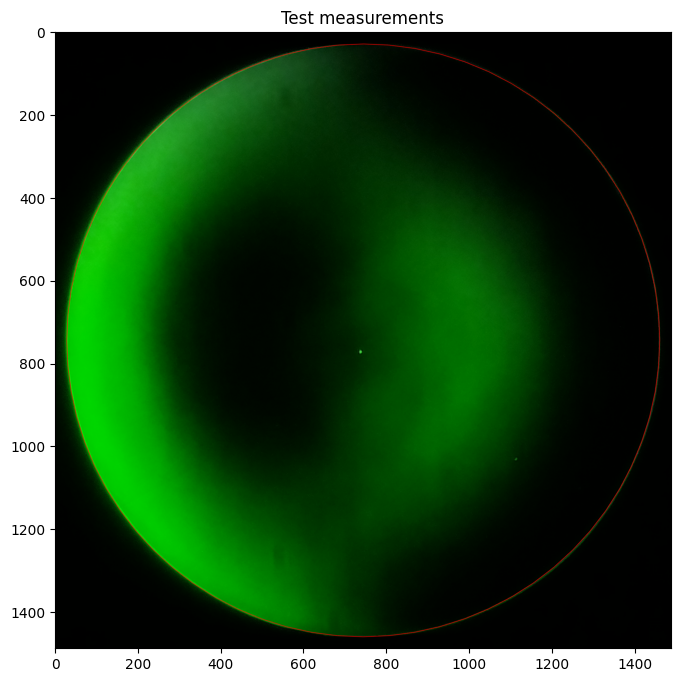

In [10]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
plt.imshow(capture_ellipse[center[1]-radius-circle_radius_tolerance:center[1]+radius+circle_radius_tolerance,
           center[0]-radius-circle_radius_tolerance:center[0]+radius+circle_radius_tolerance])
  
# display that image
plt.show()

# Create shadowgram color histogram inside the mirror area only

In [11]:
capture_gray_hist_mask = np.full_like(capture_gray, 0)
capture_gray_hist_mask = cv2.ellipse(capture_gray_hist_mask, ellipse, color_ellipse, -1, cv2.LINE_AA)

capture_gray_hist = cv2.calcHist([capture_gray], [0], capture_gray_hist_mask, [256], [0,256])

In [12]:
capture_gray_hist_cdf = np.cumsum(capture_gray_hist)
median_cdf = np.around(capture_gray_hist_cdf[-1]/2)
capture_gray_median_color = (np.abs(capture_gray_hist_cdf - median_cdf)).argmin()

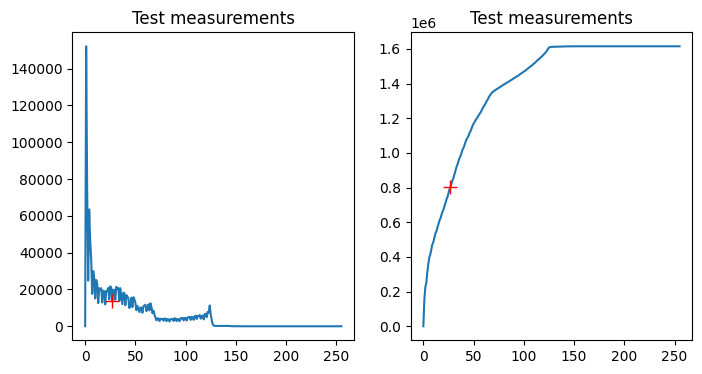

In [13]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 4]
#plt.rcParams['figure.dpi'] = 120

plt.subplot(1, 2, 1)
plt.title('Test measurements')
plt.plot(capture_gray_hist)
plt.plot(capture_gray_median_color, capture_gray_hist[capture_gray_median_color],
         "r+", markersize=10)

plt.subplot(1, 2, 2)
plt.title('Test measurements')
plt.plot(capture_gray_hist_cdf)
plt.plot(capture_gray_median_color, capture_gray_hist_cdf[capture_gray_median_color],
         "r+", markersize=10)

# display plots
plt.show()

# Segment shadow and light areas on the shadowgram

In [14]:
threshold = capture_gray_median_color
_, capture_thresh = cv2.threshold(capture_gray_blur, threshold, 255, cv2.THRESH_BINARY)

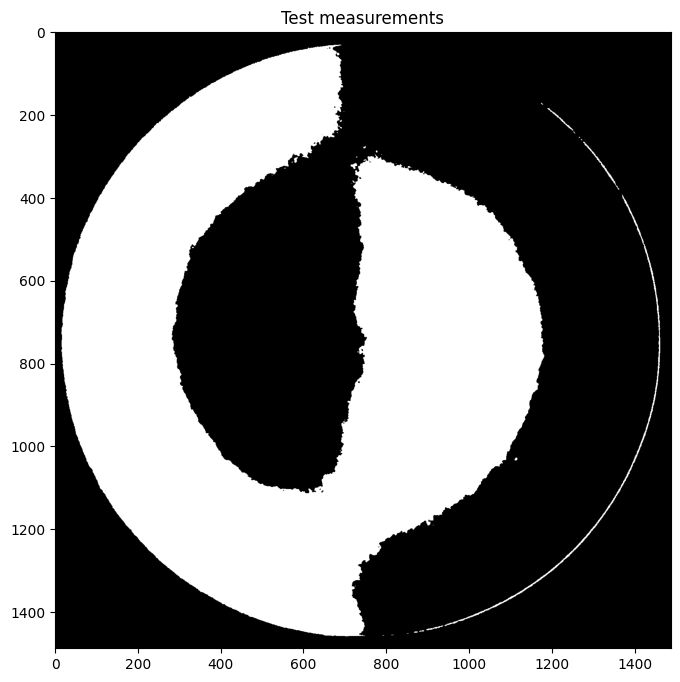

In [15]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
#plt.imshow(capture_thresh, cmap='gray')
plt.imshow(capture_thresh[center[1]-radius-circle_radius_tolerance:center[1]+radius+circle_radius_tolerance,
           center[0]-radius-circle_radius_tolerance:center[0]+radius+circle_radius_tolerance], cmap='gray')

# display that image
plt.show()

# Determine shadowgram segment transitions across horizontal diameter

In [16]:
sample_height = 30
capture_sample = capture_thresh[center[1]-sample_height:center[1]+sample_height, :]

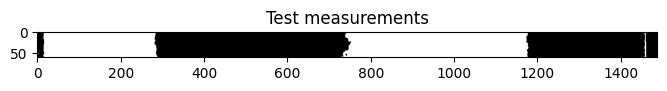

In [17]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]
#plt.rcParams['figure.dpi'] = 120

plt.title('Test measurements')

# call imshow() using plt object
#plt.imshow(capture_thresh, cmap='gray')
plt.imshow(capture_sample[:, center[0]-radius-circle_radius_tolerance:center[0]+radius+circle_radius_tolerance], cmap='gray')

# display that image
plt.show()

In [18]:
from scipy.signal import find_peaks

capture_sample_averaged = np.mean(capture_sample, axis=0)
capture_sample_transitions = np.absolute(np.gradient(capture_sample_averaged))

capture_sample_transition_peaks, _ = find_peaks(capture_sample_transitions, height=25, distance=50)

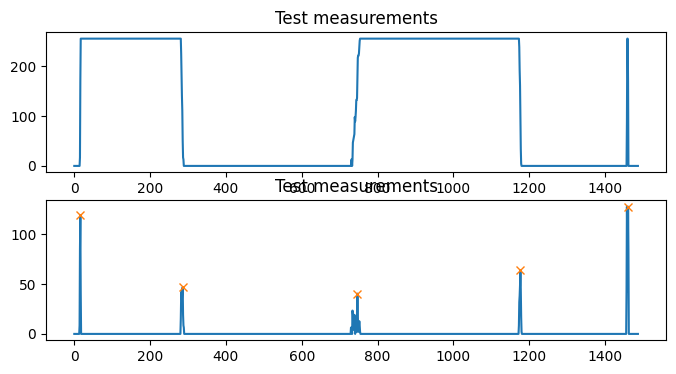

In [23]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 4]
#plt.rcParams['figure.dpi'] = 120

plt.subplot(2, 1, 1)
plt.title('Test measurements')
plt.plot(capture_sample_averaged[center[0]-radius-circle_radius_tolerance:center[0]+radius+circle_radius_tolerance])

plt.subplot(2, 1, 2)
plt.title('Test measurements')
plt.plot(capture_sample_transitions[center[0]-radius-circle_radius_tolerance:center[0]+radius+circle_radius_tolerance])
plt.plot(capture_sample_transition_peaks-center[0]+radius+circle_radius_tolerance,
         capture_sample_transitions[capture_sample_transition_peaks], "x")

# display plots
plt.show()

# Determine transition 

In [20]:
print(capture_sample_transition_peaks)

[ 824 1094 1555 1985 2269]
